### Exploratory Data Analysis

In this notebook, let us present useful charts that coul be used to get intuition about the data. We will divide the exploratory data analysis into topics to help make more conclusions about the dataset.

In each topic, we will try to purpose questions that can be answered with some graphic or table analysis.

In [93]:
import sys
sys.path.append('../../../')

In [232]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(18.7,16.27)})
from matplotlib.gridspec import GridSpec
#from matplotlib.axes import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

import folium
from folium.plugins import HeatMap, FastMarkerCluster

from geopy.geocoders import Nominatim


from vis.vis_utils import *

In [161]:
restaurants = pd.read_pickle('../datasets/unprocessed_clean/businesses_data_cleaned.pkl')
reviews = pd.read_pickle('../datasets/unprocessed_clean/businesses_reviews_cleaned.pkl')

In this topic, let's make an initial analysis on our data looking at restaurant's features presented in it.

######  - <i>How many categories of restaurants we have?</i>

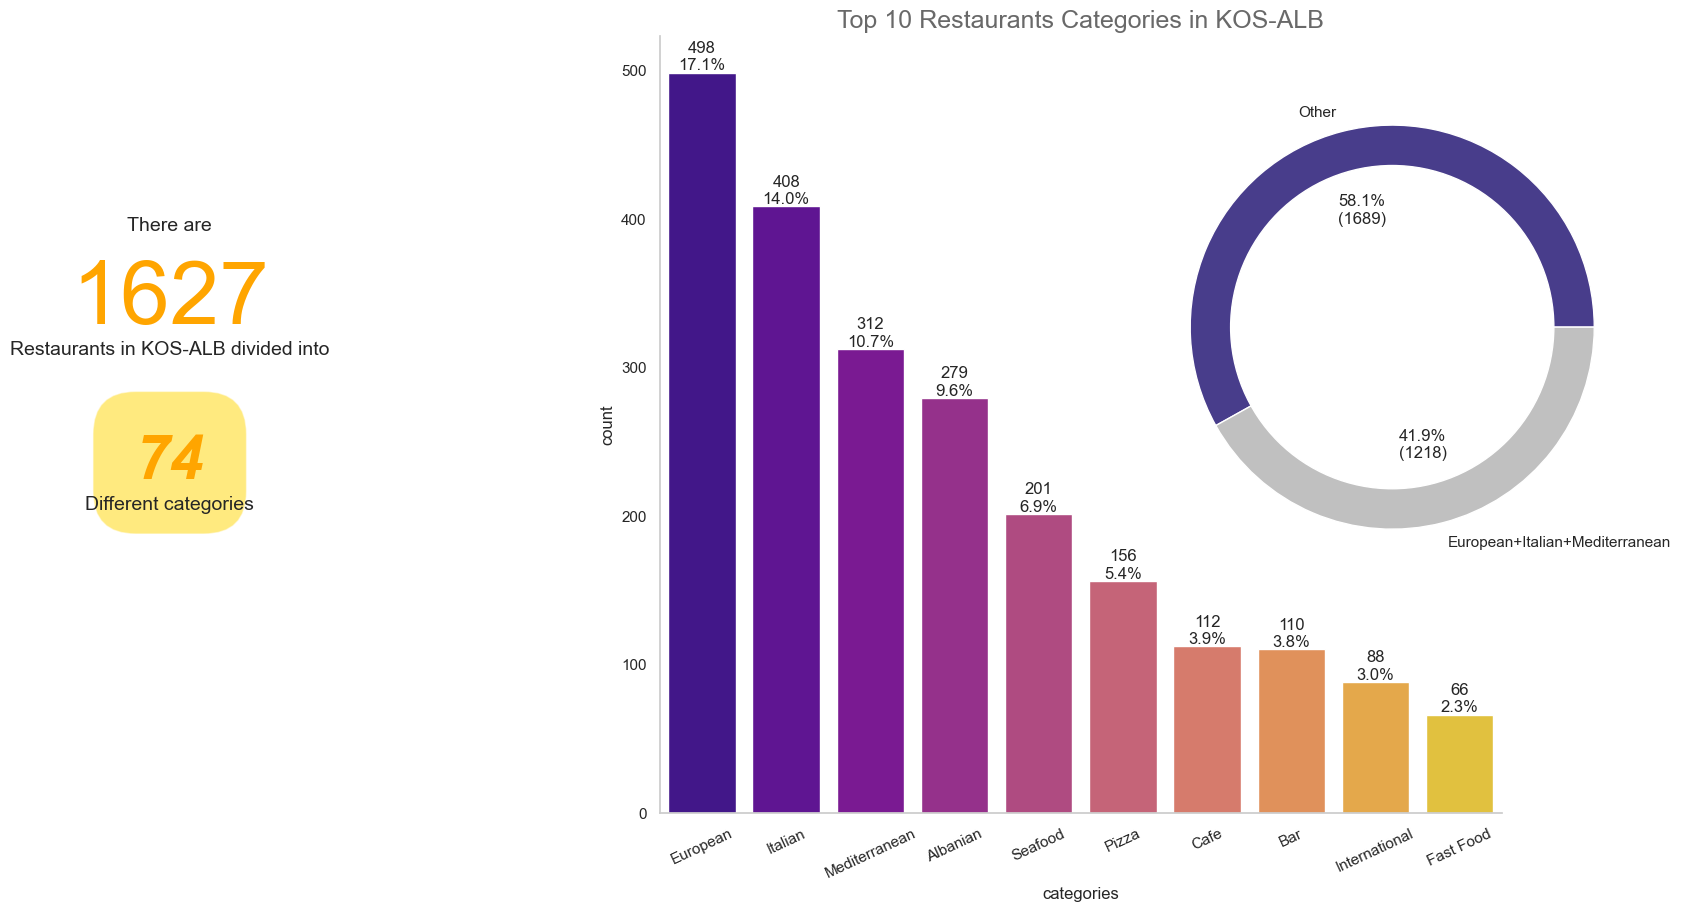

In [173]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 9))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

data_to_plot = restaurants.explode('categories').dropna()

# Axis 1 - Big Number for total restaurants and total types in the data
total_restaurants = len(restaurants)
total_types = len(data_to_plot['categories'].value_counts())
ax1.text(0.00, 0.75, 'There are', fontsize=14, ha='center')
ax1.text(0.00, 0.63, f'{total_restaurants}', fontsize=64, color='orange', ha='center')
ax1.text(0, 0.59, 'Restaurants in KOS-ALB divided into', fontsize=14, ha='center')
ax1.text(0.00, 0.43, total_types, fontsize=44, ha='center', color='orange', style='italic', weight='bold',
         bbox=dict(facecolor='gold', alpha=0.5, pad=14, boxstyle='round, pad=.7'))
ax1.text(0, 0.39, 'Different categories', fontsize=14, ha='center')
ax1.axis('off')

# Axis 2 - Total number of restaurants per type (Top N)
top = 10
single_countplot(data_to_plot, ax2, x='categories', top=top)
ax2.set_title(f'Top {top} Restaurants Categories in KOS-ALB', color='dimgrey', size=18)
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)
    

    # Axis 3 - Representative of the top two restaurant type
data_to_plot['top_types'] = data_to_plot['categories'].apply(lambda x: 'European+Italian+Mediterranean' if x in ('European', 'Italian', 'Mediterranean') else 'Other')
ax3 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax2, [0.57, 0.3, 0.6, 0.65])
ax3.set_axes_locator(ip)
donut_plot(data_to_plot, col='top_types', ax=ax3, colors=['darkslateblue', 'silver'], title='')


###### - <i>What are the most popular restaurants</i>?

For answearing the question above, let's group our data into some numerical variables that could probably show a good overview from restaurant's indicators like <b>total votes</b>, <b>mean approx cost</b>, <b>rate</b> and <b>others</b>. By the end, we will have in hands a new DataFrame with grouped information about all the restaurant's franchise in the dataset.

It's important to say that here we are grouping by restaurant name and, as long as there are restaurants with the same name in the dataset (same name but different locations, for example), we will also see how many unities each "franchise" have.

In [136]:
popular_franchises = restaurants.groupby(by='business_name', as_index=False).agg({'review_count': 'sum',
                                                                            'url': 'count',
                                                                            'price_tag': 'mean',
                                                                            'stars': 'mean'})
popular_franchises.columns = ['name', 'total_votes', 'total_unities', 'mean_approx_cost', 'mean_rate_num']
popular_franchises['votes_per_unity'] = popular_franchises['total_votes'] / popular_franchises['total_unities']
popular_franchises = popular_franchises.sort_values(by='total_unities', ascending=False)
popular_franchises = popular_franchises.loc[:, ['name', 'total_unities', 'total_votes', 'votes_per_unity',
                                                'mean_approx_cost', 'mean_rate_num']]

In [137]:
popular_franchises

,name,total_unities,total_votes,votes_per_unity,mean_approx_cost,mean_rate_num
1004,Proper Pizza,3,114.0,38.000000,1.5,4.166667
715,Mangiafuoco Bracerie Sapori Toscani,3,47.0,15.666667,1.0,3.333333
1220,Sarajeva Steak House,3,11.0,3.666667,2.5,2.500000
1096,Restaurant Natyra,3,21.0,7.000000,1.0,4.833333
165,Bella Vista,2,32.0,16.000000,2.5,4.250000
...,...,...,...,...,...,...
530,Heksamil Restaurant,1,0.0,0.000000,4.0,0.000000
529,Heat Restaurant,1,7.0,7.000000,1.0,4.500000
528,Happy Vjeter,1,0.0,0.000000,1.0,0.000000
527,Happy Times,1,6.0,6.000000,2.5,5.000000


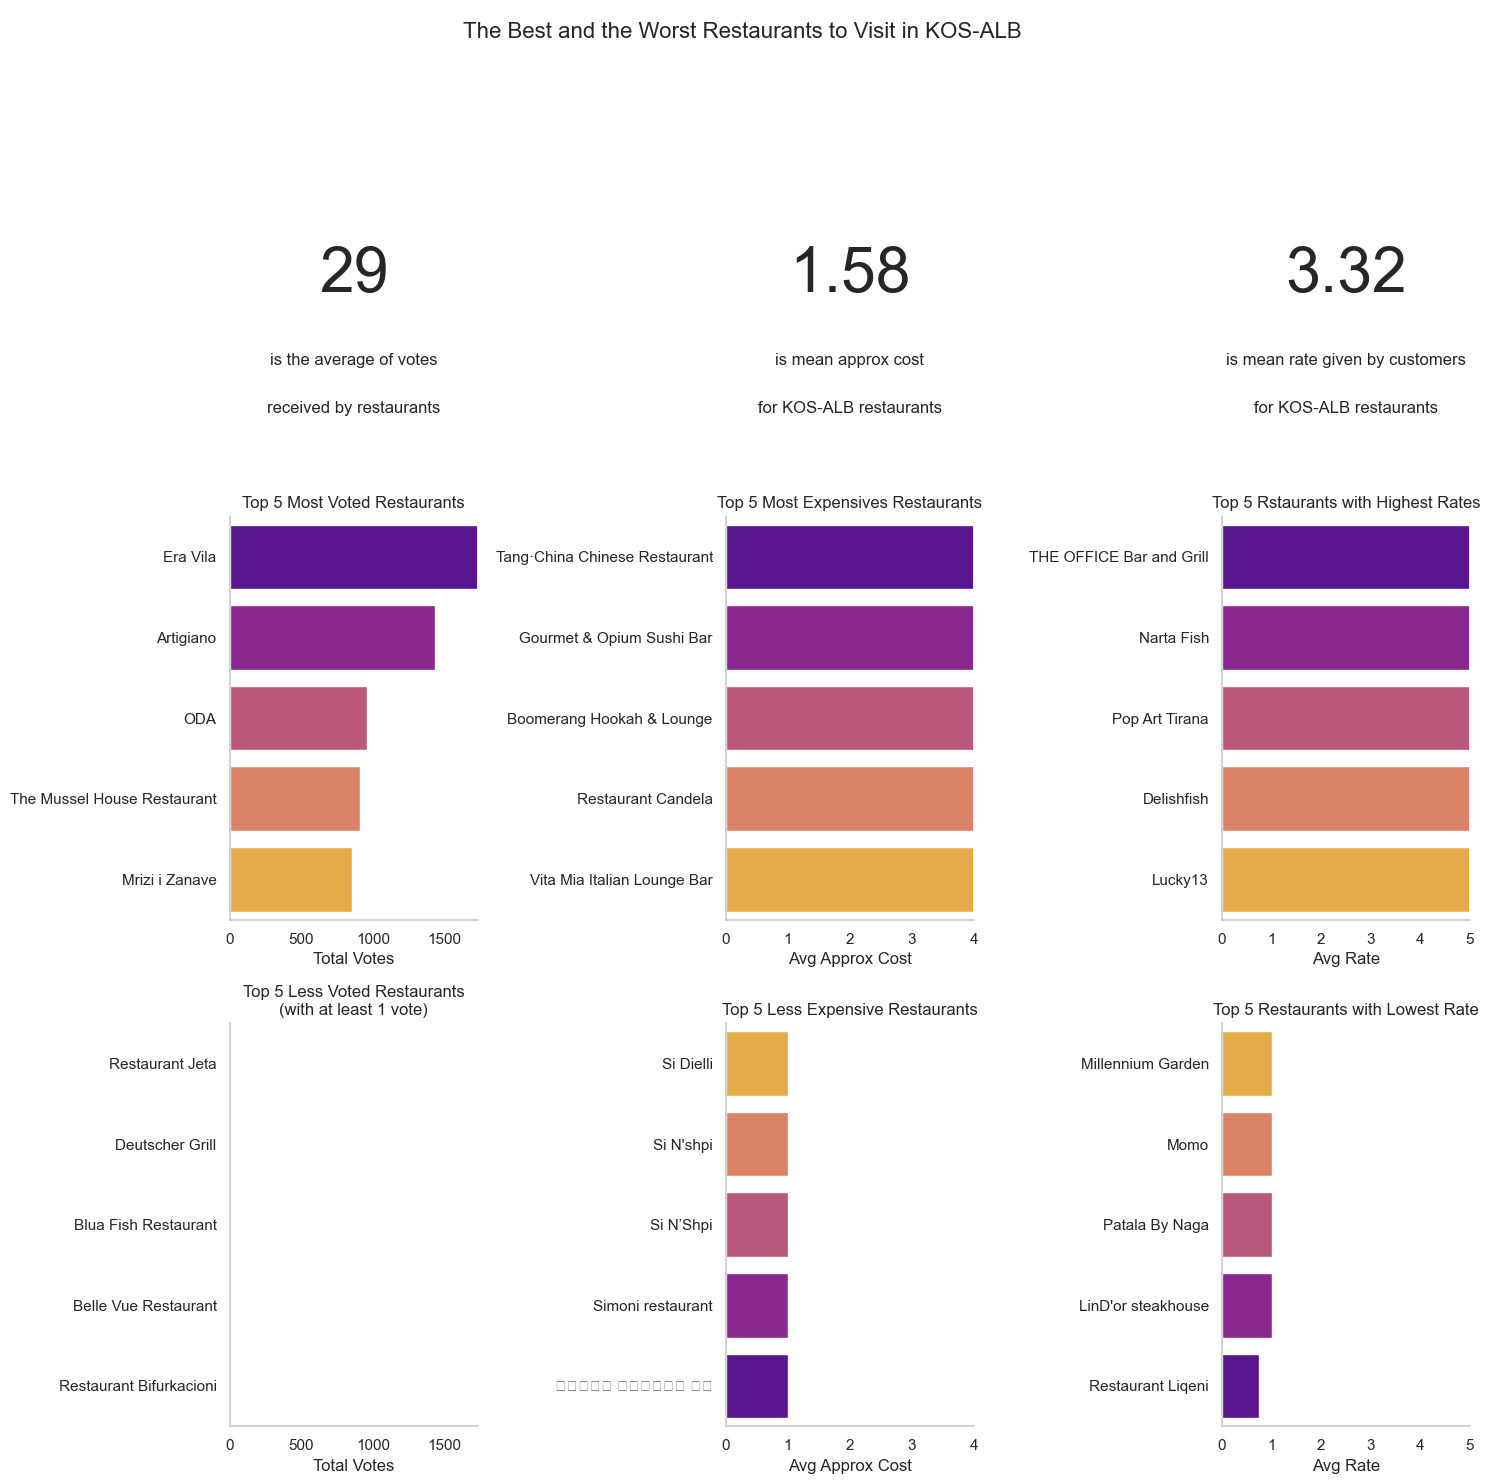

In [140]:
# Creating a figure por restaurants overview analysis
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot Pack 01 - Most popular restaurants (votes)
sns.barplot(x='total_votes', y='name', data=popular_franchises.sort_values(by='total_votes', ascending=False).head(),
            ax=axs[1, 0], palette='plasma')
axs[1, 0].set_title('Top 5 Most Voted Restaurants', size=12)
sns.barplot(x='total_votes', y='name', 
            data=popular_franchises.sort_values(by='total_votes', ascending=False).query('total_votes > 0').tail(),
            ax=axs[2, 0], palette='plasma_r')
axs[2, 0].set_title('Top 5 Less Voted Restaurants\n(with at least 1 vote)', size=12)
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Total Votes')
    ax.set_xlim(0, popular_franchises['total_votes'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 0].text(0.50, 0.30, int(popular_franchises.total_votes.mean()), fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, 'is the average of votes', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'received by restaurants', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Cost analysis
sns.barplot(x='mean_approx_cost', y='name', data=popular_franchises.sort_values(by='mean_approx_cost', ascending=False).head(),
            ax=axs[1, 1], palette='plasma')
axs[1, 1].set_title('Top 5 Most Expensives Restaurants', size=12)
sns.barplot(x='mean_approx_cost', y='name', 
            data=popular_franchises.sort_values(by='mean_approx_cost', ascending=False).query('mean_approx_cost > 0').tail(),
            ax=axs[2, 1], palette='plasma_r')
axs[2, 1].set_title('Top 5 Less Expensive Restaurants', size=12)
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Avg Approx Cost')
    ax.set_xlim(0, popular_franchises['mean_approx_cost'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 1].text(0.50, 0.30, round(popular_franchises.mean_approx_cost.mean(), 2), fontsize=45, ha='center')
axs[0, 1].text(0.50, 0.12, 'is mean approx cost', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'for KOS-ALB restaurants', fontsize=12, ha='center')
axs[0, 1].axis('off')

# Plot Pack 03 - Rate analysis
sns.barplot(x='mean_rate_num', y='name', data=popular_franchises.sort_values(by='mean_rate_num', ascending=False).head(),
            ax=axs[1, 2], palette='plasma')
axs[1, 2].set_title('Top 5 Rstaurants with Highest Rates', size=12)
sns.barplot(x='mean_rate_num', y='name', 
            data=popular_franchises.sort_values(by='mean_rate_num', ascending=False).query('mean_rate_num > 0').tail(),
            ax=axs[2, 2], palette='plasma_r')
axs[2, 2].set_title('Top 5 Restaurants with Lowest Rate', size=12)
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Avg Rate')
    ax.set_xlim(0, popular_franchises['mean_rate_num'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 2].text(0.50, 0.30, round(popular_franchises.mean_rate_num.mean(), 2), fontsize=45, ha='center')
axs[0, 2].text(0.50, 0.12, 'is mean rate given by customers', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'for KOS-ALB restaurants', fontsize=12, ha='center')
axs[0, 2].axis('off')

plt.tight_layout()
plt.suptitle('The Best and the Worst Restaurants to Visit in KOS-ALB', size=16)
plt.show()

How many restaurants are Claimed? And how about Closed?

Well, with the chart above we purpose a really good look at the KOS-ALB scenario: we chose three numerical features (total votes, mean approx cost and rate). Now let's use other useful features of our dataset to understand how these numerical features can be changed along the services restaurants offers, like is_claimed and is_closed

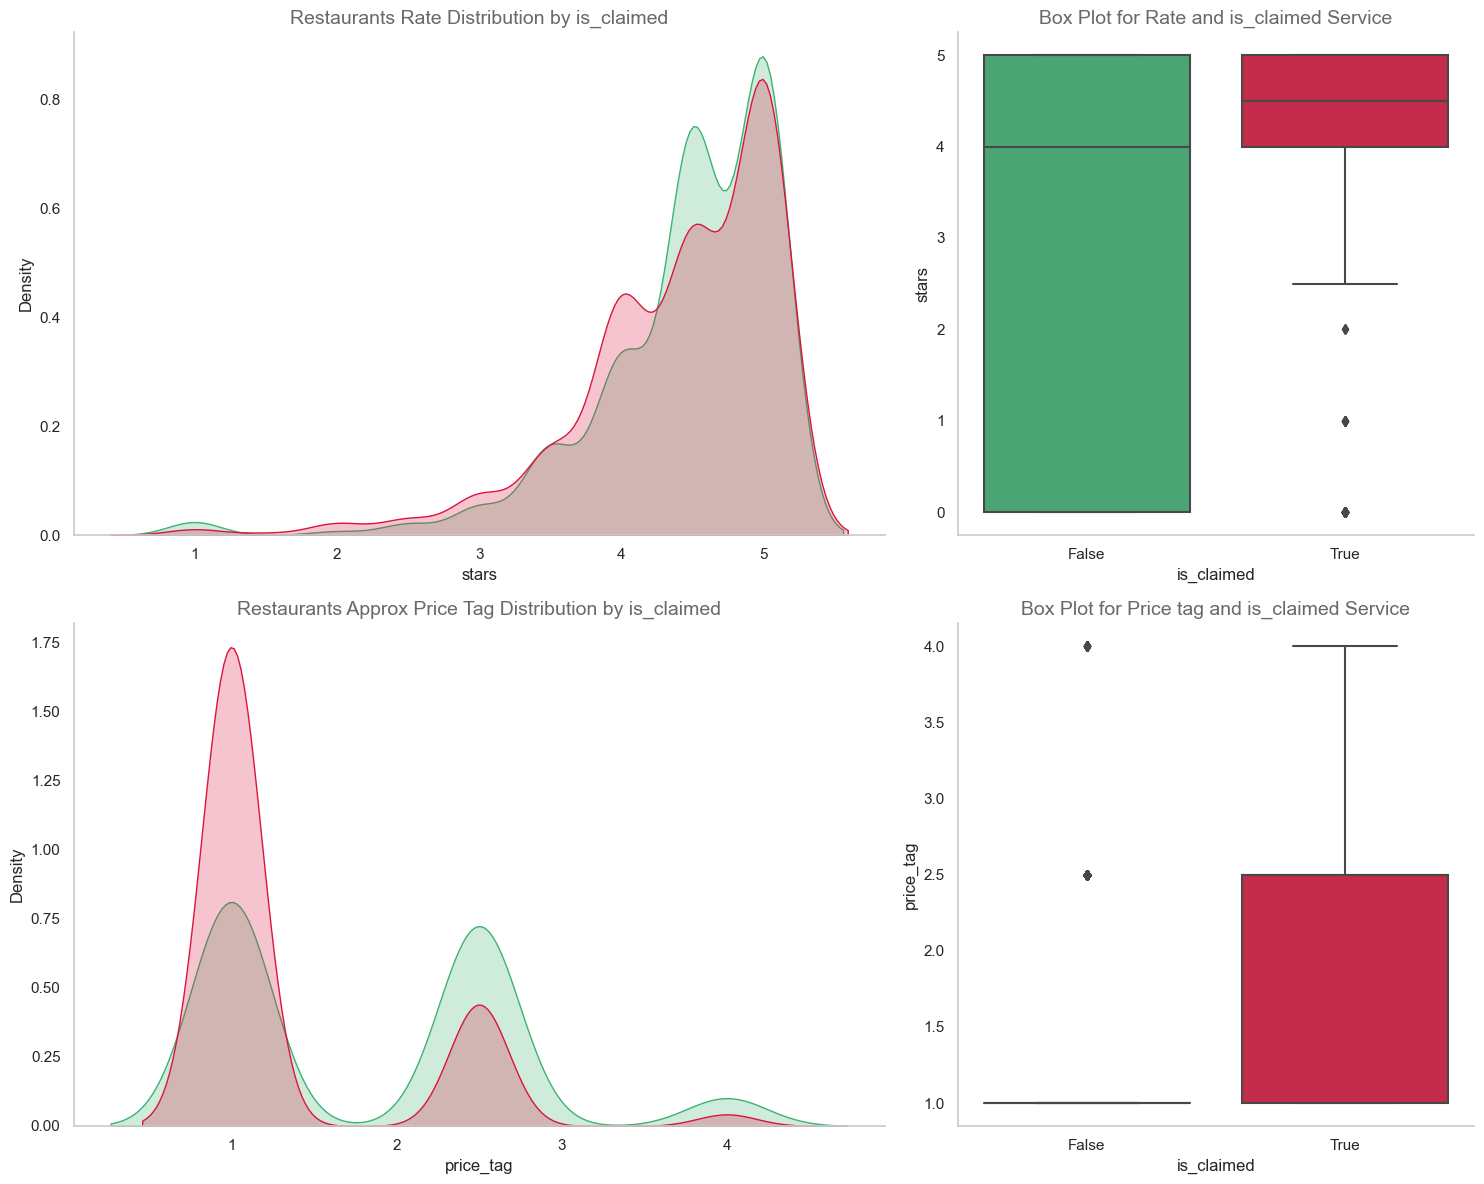

In [174]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition with GridSpec
gs = GridSpec(2, 5, figure=fig)
ax2 = fig.add_subplot(gs[0, :3])
ax3 = fig.add_subplot(gs[0, 3:])
ax4 = fig.add_subplot(gs[1, :3])
ax5 = fig.add_subplot(gs[1, 3:])

# First Line (01) - Rate
sns.kdeplot(restaurants.query('stars > 0 & is_claimed == True')['stars'], ax=ax2,
             color='mediumseagreen', shade=True, label='Claimed')
sns.kdeplot(restaurants.query('stars > 0 & is_claimed == False')['stars'], ax=ax2,
             color='crimson', shade=True, label='Non Claimed')
ax2.set_title('Restaurants Rate Distribution by is_claimed', color='dimgrey', size=14)
sns.boxplot(x='is_claimed', y='stars', data=restaurants, palette=['mediumseagreen', 'crimson'], ax=ax3)
ax3.set_title('Box Plot for Rate and is_claimed Service', color='dimgrey', size=14)

# First Line (01) - Cost
sns.kdeplot(restaurants.query('price_tag > 0 & is_claimed==True')['price_tag'], ax=ax4,
             color='mediumseagreen', shade=True, label='With Book Table Service')
sns.kdeplot(restaurants.query('price_tag > 0 & is_claimed==False')['price_tag'], ax=ax4,
             color='crimson', shade=True, label='Without Book Table Service')
ax4.set_title('Restaurants Approx Price Tag Distribution by is_claimed', color='dimgrey', size=14)
sns.boxplot(x='is_claimed', y='price_tag', data=restaurants, palette=['mediumseagreen', 'crimson'], ax=ax5)
ax5.set_title('Box Plot for Price tag and is_claimed Service', color='dimgrey', size=14)


# Customizing plots
for ax in [ax2, ax3, ax4, ax5]:
    format_spines(ax, right_border=False)
    
plt.tight_layout()

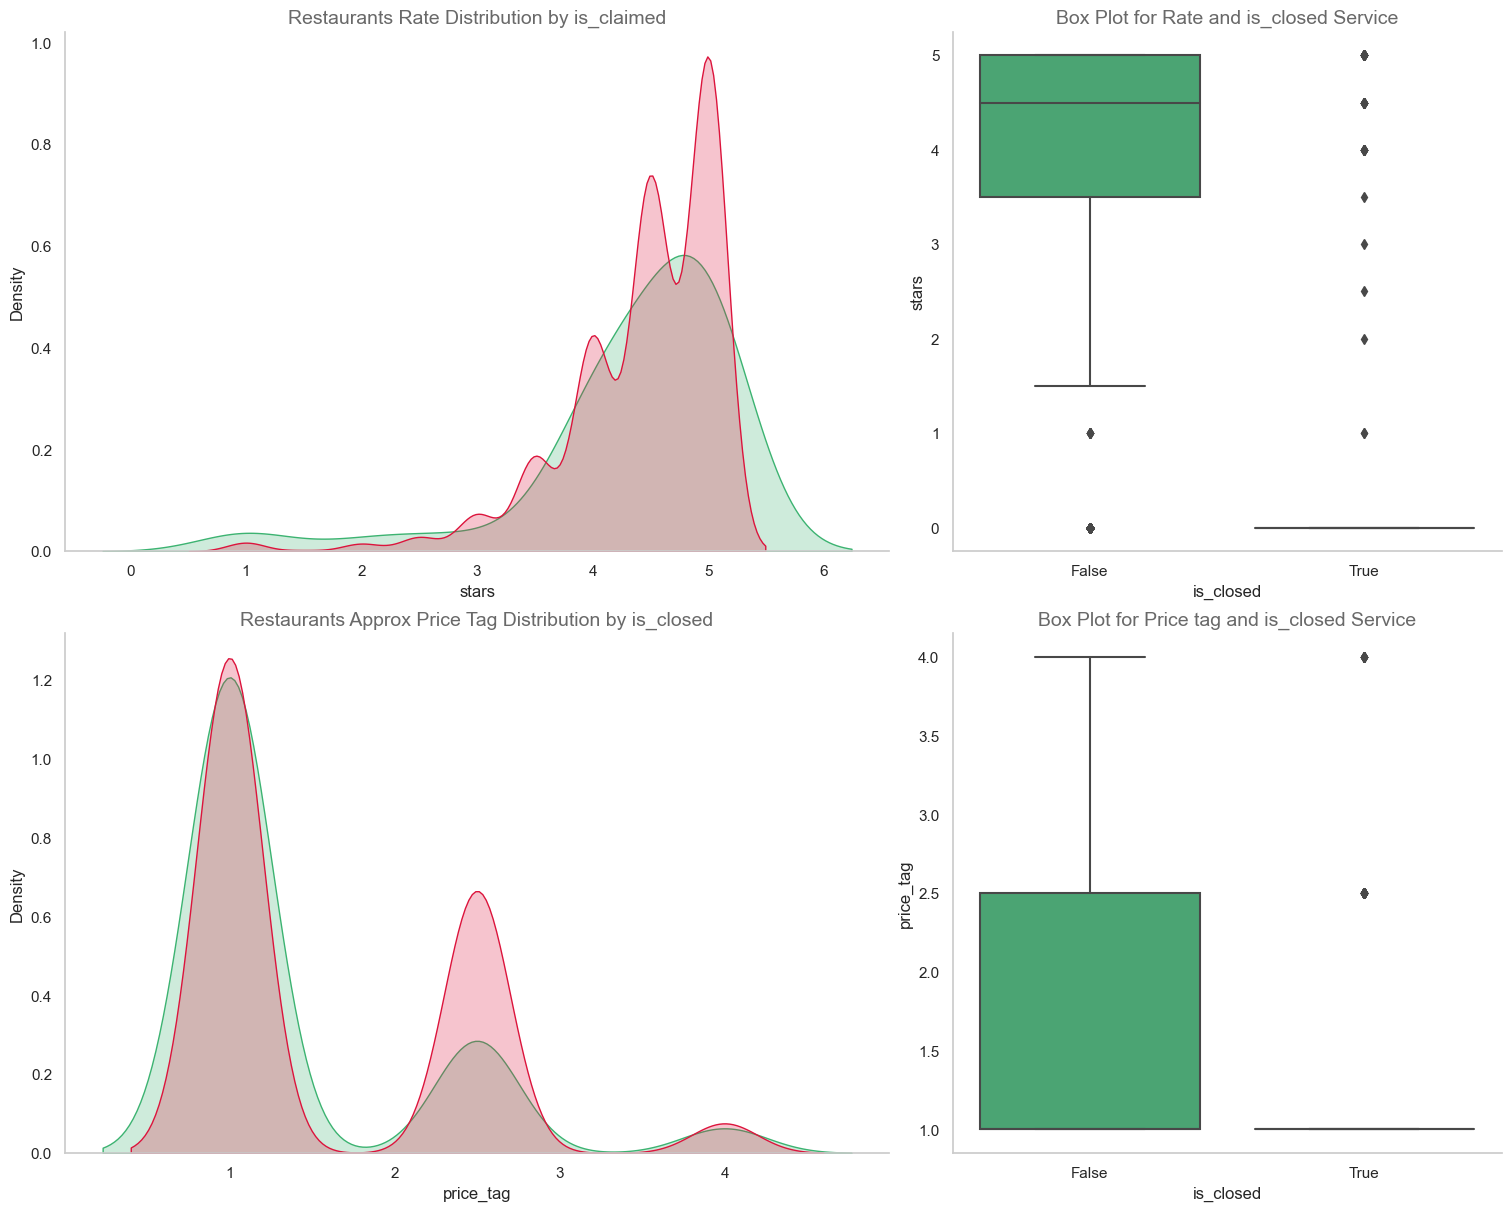

In [175]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition with GridSpec
gs = GridSpec(2, 5, figure=fig)
ax2 = fig.add_subplot(gs[0, :3])
ax3 = fig.add_subplot(gs[0, 3:])
ax4 = fig.add_subplot(gs[1, :3])
ax5 = fig.add_subplot(gs[1, 3:])

# First Line (01) - Rate
sns.kdeplot(restaurants.query('stars > 0 & is_closed == True')['stars'], ax=ax2,
             color='mediumseagreen', shade=True, label='Claimed')
sns.kdeplot(restaurants.query('stars > 0 & is_closed == False')['stars'], ax=ax2,
             color='crimson', shade=True, label='Non Claimed')
ax2.set_title('Restaurants Rate Distribution by is_claimed', color='dimgrey', size=14)
sns.boxplot(x='is_closed', y='stars', data=restaurants, palette=['mediumseagreen', 'crimson'], ax=ax3)
ax3.set_title('Box Plot for Rate and is_closed Service', color='dimgrey', size=14)

# First Line (01) - Cost
sns.kdeplot(restaurants.query('price_tag > 0 & is_closed==True')['price_tag'], ax=ax4,
             color='mediumseagreen', shade=True, label='With Book Table Service')
sns.kdeplot(restaurants.query('price_tag > 0 & is_closed==False')['price_tag'], ax=ax4,
             color='crimson', shade=True, label='Without Book Table Service')
ax4.set_title('Restaurants Approx Price Tag Distribution by is_closed', color='dimgrey', size=14)
sns.boxplot(x='is_closed', y='price_tag', data=restaurants, palette=['mediumseagreen', 'crimson'], ax=ax5)
ax5.set_title('Box Plot for Price tag and is_closed Service', color='dimgrey', size=14)


# Customizing plots
for ax in [ax2, ax3, ax4, ax5]:
    format_spines(ax, right_border=False)
    

###### Where Are the Good Ones?


Searching for useful insights for maybe predicting the success of a restaurant in Kos-Alb, let's dive into locations to answer the question in the session title. By the way, where are the good restaurants?*

*Good restaurants are relative and we will point that the the good ones have a high rate.

In [190]:
popular_franchises.reset_index(drop=True, inplace=True)

In [260]:
popular_franchises['is_closed'] = np.nan
for i, name in enumerate(popular_franchises['name']):
    is_closed = restaurants[restaurants['business_name'] == name]['is_closed']
    is_closed = is_closed.reset_index(drop=True)[0]
    popular_franchises.loc[i, 'is_closed'] = is_closed
    
# Grouping data into location
good_ones = restaurants.groupby(by='city', as_index=False).agg({'review_count': 'sum',
                                                                       'url': 'count',
                                                                       'price_tag': 'mean',
                                                                       'stars': 'mean'})
good_ones.columns = ['location', 'total_votes', 'total_unities', 'mean_approx_cost', 'mean_rate_num']
good_ones['votes_per_unity'] = good_ones['total_votes'] / good_ones['total_unities']
good_ones = good_ones.sort_values(by='total_unities', ascending=False)
good_ones = good_ones.loc[:, ['location', 'total_unities', 'total_votes', 'votes_per_unity',
                                                'mean_approx_cost', 'mean_rate_num']]
good_ones.head(10)

,location,total_unities,total_votes,votes_per_unity,mean_approx_cost,mean_rate_num
26,Tirana County,830,29306.0,35.308434,1.630723,3.473494
16,Pristina,320,5402.0,16.881250,1.576563,3.175000
27,Vlore County,156,7884.0,50.538462,1.625000,3.666667
17,Prizren,61,1055.0,17.295082,1.614754,3.229508
10,Lezhe County,55,1757.0,31.945455,1.490909,3.745455
4,Gjakova,48,109.0,2.270833,1.218750,1.812500
13,Pec,29,449.0,15.482759,1.310345,2.965517
3,Ferizaj,27,60.0,2.222222,1.388889,2.462963
11,Mitrovica,18,106.0,5.888889,1.500000,3.222222
9,Klina,14,14.0,1.000000,1.428571,1.535714


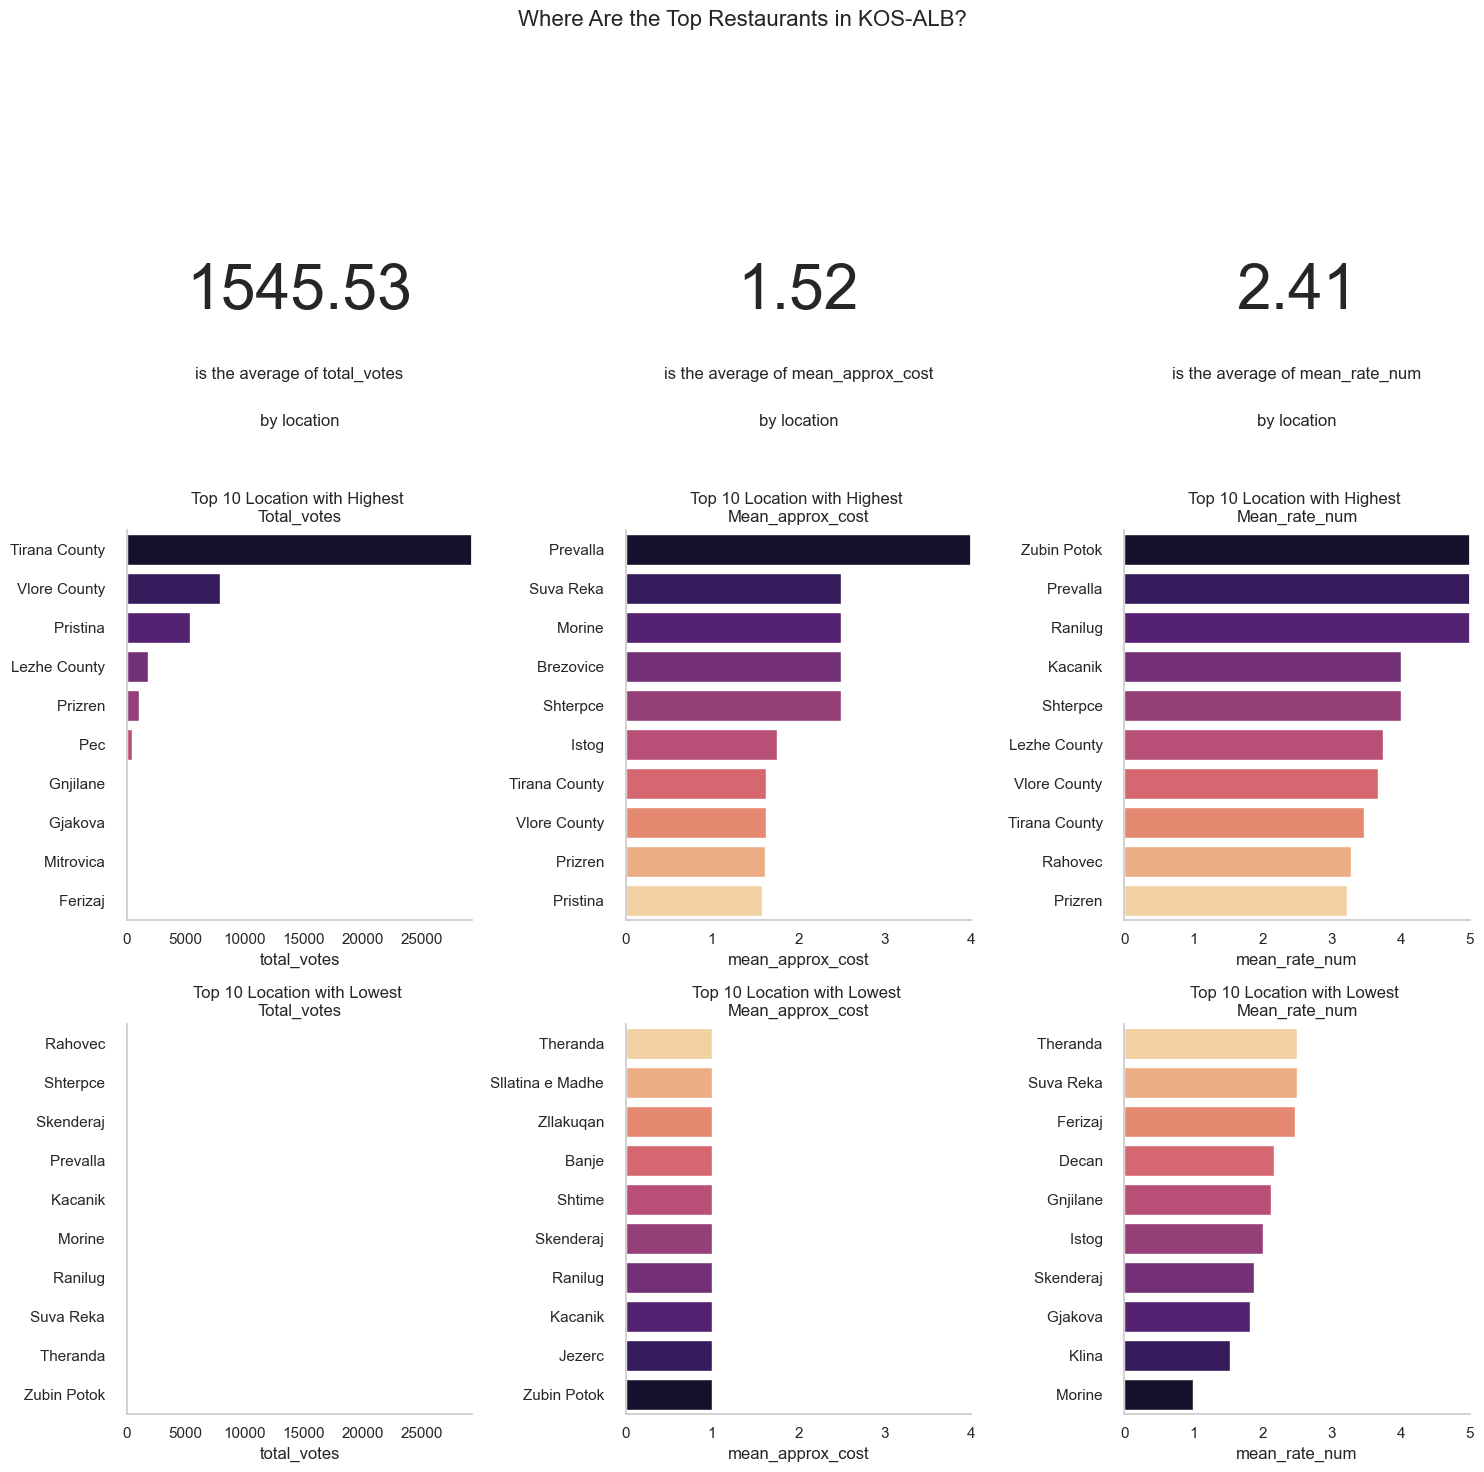

In [261]:
# Creating a figure por restaurants overview analysis
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
list_cols = ['total_votes', 'mean_approx_cost', 'mean_rate_num']

# PLotting best and worst by grouped data
answear_plot(grouped_data=good_ones, grouped_col='location', axs=axs, list_cols=list_cols, top=10, palette='magma')

# Finishing the chart
plt.suptitle('Where Are the Top Restaurants in KOS-ALB?', size=16)
plt.tight_layout()
plt.show()

##### City group

Now let's purpose a clearly view for cities with restaurants in Kos-Alb and take a look at the average price_tag and stars of restaurants in each one. The idea is to see how these two variables are related and to present customers the insight of choosing the best city to visit (eating purposes) in Kos-Alb.

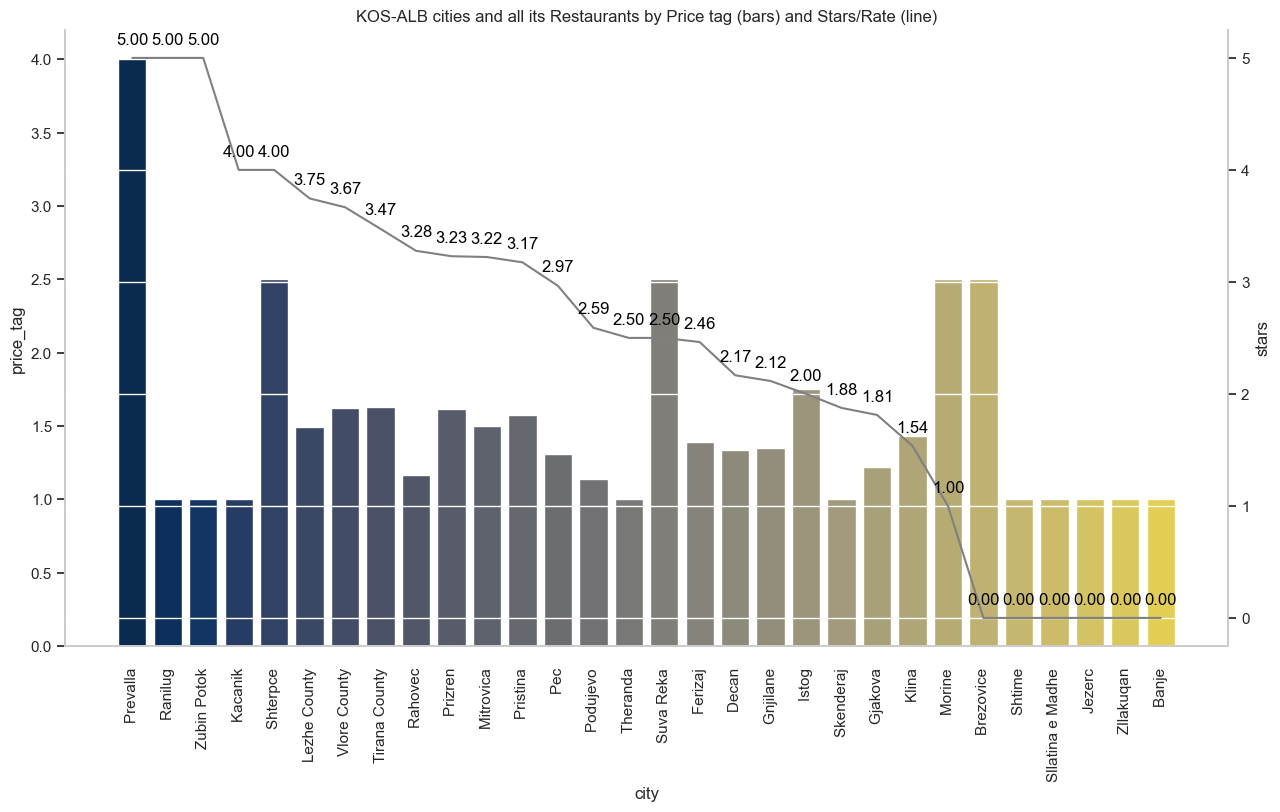

In [265]:
# Grouping data by city
city_group = restaurants.groupby(by='city', as_index=False).agg({'stars': 'mean',
                                                                'price_tag': 'mean'})
city_group.sort_values(by='stars', ascending=False, inplace=True)

# Ploting
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='city', y='price_tag', data=city_group, palette='cividis', 
            order=city_group['city'])
ax2 = ax.twinx()
sns.lineplot(x='city', y='stars', data=city_group, color='gray', ax=ax2, sort=False)

# Labeling line chart (rate)
xs = np.arange(0, len(city_group), 1)
ys = city_group['stars']
for x,y in zip(xs, ys):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 color='black')
    
# Labeling bar chart (cost)
for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{}'.format(int(y)), (x.mean(), 15), va='bottom', rotation='vertical', color='white', 
                fontweight='bold')

# Customizing chart
format_spines(ax)
format_spines(ax2)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('KOS-ALB cities and all its Restaurants by Price tag (bars) and Stars/Rate (line)')
plt.show()

###### Geo Analysis: where are the restaurants located in Kos-Alb?

In [263]:
# Zipping locations for folium map
locations = list(zip(restaurants['latitude'].values, restaurants['longitude'].values))

# Creating a map using folium
map1 = folium.Map(
    location=[41.335560, 19.49],
    zoom_start=7
)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

###### <i>How the rate and approx cost are distributed among restaurant types?</i>

IndexError: list index out of range

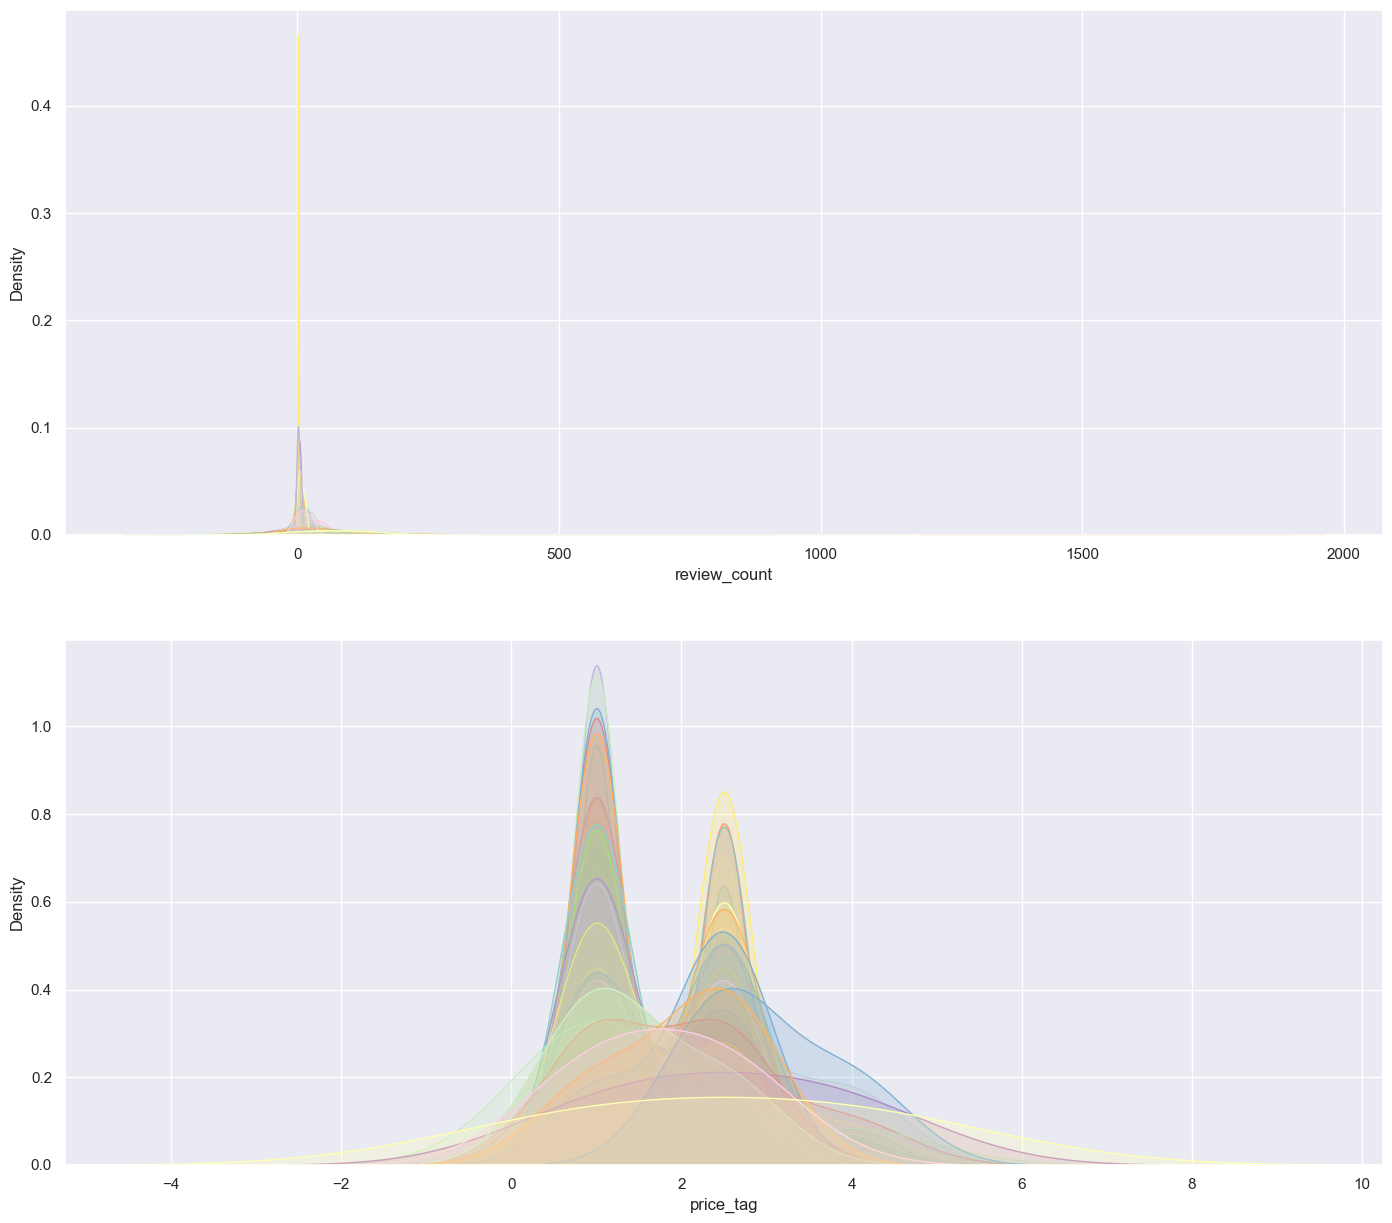

In [293]:
data_to_plot = restaurants.explode('categories').reset_index(drop=True)
rest_types = list(data_to_plot['categories'].value_counts().index)
colors = sns.color_palette('Set3', n_colors=80)
fig, axs = plt.subplots(2, 1, figsize=(17, 15))
for r_type in rest_types:
    idx = rest_types.index(r_type)
    kde_data = data_to_plot[(data_to_plot['review_count'] > 0) & (data_to_plot['categories'] == r_type)]
    sns.kdeplot(kde_data['review_count'], ax=axs[0], color=colors[idx], shade=True, label=r_type)
    sns.kdeplot(kde_data['price_tag'], ax=axs[1], color=colors[idx], shade=True, label=r_type)

# Customizing charts
axs[0].set_title('Distribution of Rate by Restaurant Category', color='dimgrey', size=18)
axs[1].set_title('Distribution of Approx Cost by Restaurant Category', color='dimgrey', size=18)
for ax in axs:
    format_spines(ax, right_border=False)
plt.tight_layout()